In [57]:
import pandas as pd
import datetime as dt 
import pandas as pd
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
import requests

In [58]:
base_url = 'https://gbfs.capitalbikeshare.com/gbfs/gbfs.json'

def main_request(url):

    r = requests.get(base_url)
    data = r.json()

    return data


def station_info(data):
    
    r = requests.get(data['data']['en']['feeds'][1]['url'])
    station_info = r.json()

    return station_info


def station_status(data):

    r = requests.get(data['data']['en']['feeds'][2]['url'])
    station_status = r.json()

    return station_status


def parse_station_status(station_status_json):

    station_status_list = []
    last_update = station_status_json['last_updated']

    for station in range(len(station_status_json['data']['stations'])):
        try:
            station_status = station_status_json['data']['stations'][station]['station_status']
            last_reported = station_status_json['data']['stations'][station]['last_reported']
            num_bikes_available = station_status_json['data']['stations'][station]['num_bikes_available']
            available_scooters = station_status_json['data']['stations'][station]['num_scooters_available']
            num_ebikes_available = station_status_json['data']['stations'][station]['num_ebikes_available']
            num_bikes_disabled = station_status_json['data']['stations'][station]['num_bikes_disabled']
            station_id = station_status_json['data']['stations'][station]['station_id']
            is_returning = station_status_json['data']['stations'][station]['is_returning']
            is_renting = station_status_json['data']['stations'][station]['is_renting']
            num_docks_disabled = station_status_json['data']['stations'][station]['num_docks_disabled']
            num_docks_available = station_status_json['data']['stations'][station]['num_docks_available']

        except KeyError:
            pass

        station_status_dict = {
            'station_status' : station_status,
            'last_reported' : dt.datetime.fromtimestamp(last_reported),
            'last_updated' : dt.datetime.fromtimestamp(last_update),
            'available_scooters': available_scooters,
            'num_bikes_available' : num_bikes_available,
            'num_bikes_disabled' : num_bikes_disabled,
            'num_ebikes_available' : num_ebikes_available,
            'station_id' : station_id,
            'is_renting' : is_renting,
            'is_returning' : is_returning,
            'num_docks_available' : num_docks_available,
            'num_docks_disabled' : num_docks_disabled
        }
        
        station_status_list.append(station_status_dict)

    return station_status_list


def parse_station_info(stations_json):

    station_list = []
    last_update = stations_json['last_updated']
     
    for station in range(len(stations_json['data']['stations'])):
        region_id = stations_json['data']['stations'][station]['region_id']
        has_kiosk = stations_json['data']['stations'][station]['has_kiosk']
        station_type = stations_json['data']['stations'][station]['station_type']
        adress = stations_json['data']['stations'][station]['name']
        capacity = stations_json['data']['stations'][station]['capacity']
        latitude = stations_json['data']['stations'][station]['lat']
        longitude = stations_json['data']['stations'][station]['lon']
        rental_methods = stations_json['data']['stations'][station]['rental_methods']
        station_id = stations_json['data']['stations'][station]['station_id']
        legacy_id = stations_json['data']['stations'][station]['legacy_id']

        station_dict = {
            'region_id' : region_id,
            'adress' : adress,
            'latitude': latitude,
            'longitude' : longitude,
            'type' : station_type,
            'has_kiosk' : has_kiosk,
            'capacity' : capacity,
            'rental_methods' : rental_methods,
            'station_id' : station_id,
            'legacy_id' : legacy_id,
            'last_updated' : dt.datetime.fromtimestamp(last_update)
        }

        station_list.append(station_dict)
        
    return station_list


def get_bike_info(data):
    
    resp = requests.get(data['data']['en']['feeds'][3]['url'])
    bike_data = resp.json()

    return bike_data


def parse_bike_info(bike_json):
    bike_list = []
    last_update = bike_json['last_updated']
    for bike in range(len(bike_json['data']['bikes'])):
        bike_id = bike_json['data']['bikes'][bike]['bike_id']
        latitude = bike_json['data']['bikes'][bike]['lat']
        longitude = bike_json['data']['bikes'][bike]['lon']
        longitude = bike_json['data']['bikes'][bike]['lon']
        type = bike_json['data']['bikes'][bike]['type']
        reserved = bike_json['data']['bikes'][bike]['is_reserved']
        disabled = bike_json['data']['bikes'][bike]['is_disabled']
        bike_dict = {
            'bike_id' : bike_id,
            'latitude': latitude,
            'longitude' : longitude,
            'bike_type' : type,
            'reserved' : reserved,
            'disabled' : disabled,
            'last_updated' : dt.datetime.fromtimestamp(last_update)
        }
        bike_list.append(bike_dict)
    return bike_list   

In [59]:
df_stations = pd.DataFrame(parse_station_info(station_info(main_request(base_url))))

In [60]:
df_stations['region_id'].value_counts()

42     374
41     110
104     69
40      61
44      55
43      31
133     27
152     10
Name: region_id, dtype: int64

### Limit Data to D.C Area

In [61]:
df_dc_area_stations = df_stations[df_stations['region_id'].isin(['42','104','43'])]

In [62]:
geometry = [Point(xy) for xy in zip(df_dc_area_stations['longitude'], df_dc_area_stations['latitude'])]
crs = {'init':'epsg:4326'}
geometry[:3]

[<POINT (-77.34 38.951)>, <POINT (-77.36 38.954)>, <POINT (-77.008 38.915)>]

In [63]:
geo_df = gpd.GeoDataFrame(df_dc_area_stations, #specify our data
                          crs=crs, #specify our coordinate reference system
                          geometry=geometry) #specify the geometry list we created
geo_df.crs

/Users/maxremme/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<Geographic 2D CRS: +init=epsg:4326 +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [73]:
df_dc_area_stations.iloc[1,10]

Timestamp('2023-07-16 15:41:48')

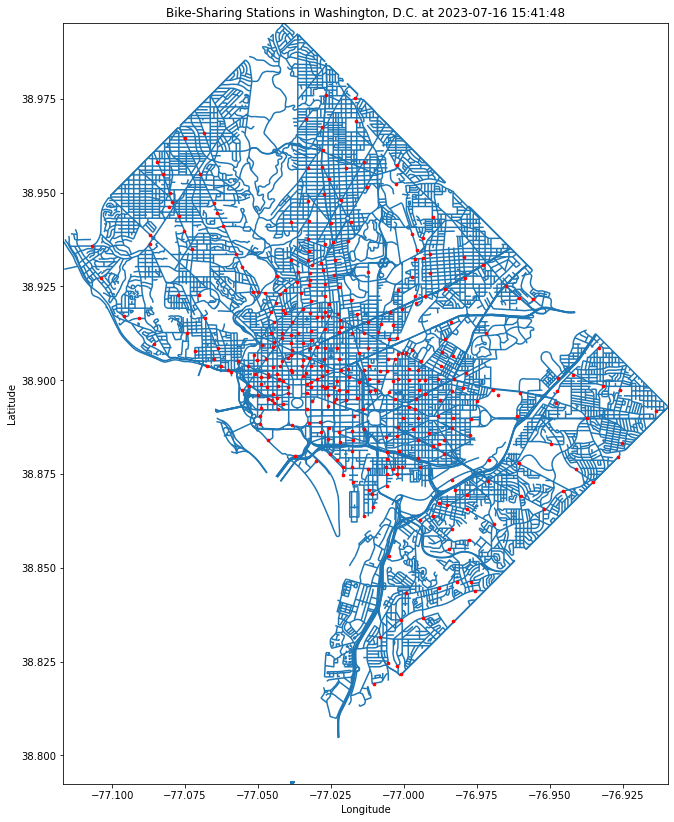

In [74]:
washington = gpd.read_file('datasets/tl_2018_11001_roads/tl_2018_11001_roads.shp')

# Create a new figure and axis

fig, ax = plt.subplots(figsize=(14, 14))
# Plot the Washington, D.C. map
washington.plot(ax=ax, zorder= 1)

# Plot the GeoDataFrame on the axis
geo_df.plot(ax=ax, marker='o', color='red', markersize=7, zorder=2)

# Set the plot extent to Washington, D.C.
ax.set_xlim(washington.total_bounds[0], washington.total_bounds[2])
ax.set_ylim(washington.total_bounds[1], washington.total_bounds[3])

updated_time = df_dc_area_stations.iloc[1,10]

# Customize the map appearance (optional)
ax.set_title(f"Bike-Sharing Stations in Washington, D.C. at {updated_time}")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Display the map
plt.show()

In [ ]:
df_bikes = pd.DataFrame(parse_bike_info(get_bike_info(main_request(base_url))))

In [ ]:
df_bikes.head()

,bike_id,latitude,longitude,bike_type,reserved,disabled,last_updated
0,dded29589cc6e85eb0804835ad868cbd,38.905428,-77.078034,electric_bike,0,0,2023-07-16 15:39:07
1,bc5f004c92b4916e2fa90de97f7ffa2c,38.813053,-77.123207,electric_bike,0,0,2023-07-16 15:39:07
2,b37d988e20f005e43d58b9f180a9f839,38.838485,-77.108741,electric_bike,0,0,2023-07-16 15:39:07
3,052e5d474a437b2b09f2bba4272900b0,38.986693,-77.000011,electric_bike,0,0,2023-07-16 15:39:07
4,8e70c4a7d5a7a9f23134d1ffa513b431,38.960229,-77.009338,electric_bike,0,0,2023-07-16 15:39:07


In [ ]:
geometry = [Point(xy) for xy in zip(df_bikes['longitude'], df_bikes['latitude'])]
crs = {'init':'epsg:4326'}
geometry[:3]

[<POINT (-77.078 38.905)>, <POINT (-77.123 38.813)>, <POINT (-77.109 38.838)>]

In [ ]:
geo_df = gpd.GeoDataFrame(df_bikes, #specify our data
                          crs=crs, #specify our coordinate reference system
                          geometry=geometry) #specify the geometry list we created

/Users/maxremme/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


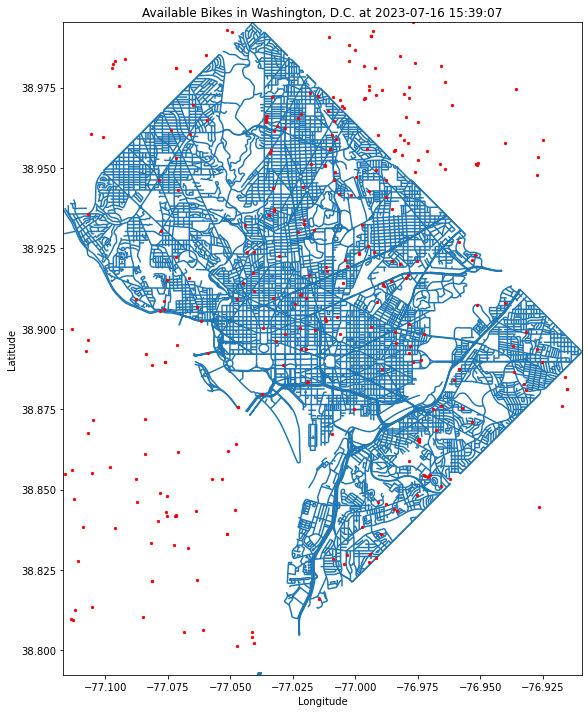

In [ ]:
washington = gpd.read_file('datasets/tl_2018_11001_roads/tl_2018_11001_roads.shp')

# Create a new figure and axis

fig, ax = plt.subplots(figsize=(12, 12))
# Plot the Washington, D.C. map
washington.plot(ax=ax, zorder= 1)

# Plot the GeoDataFrame on the axis
geo_df.plot(ax=ax, marker='o', color='red', markersize=5, zorder=2)

# Set the plot extent to Washington, D.C.
ax.set_xlim(washington.total_bounds[0], washington.total_bounds[2])
ax.set_ylim(washington.total_bounds[1], washington.total_bounds[3])

updated_time = df_bikes.iloc[1,10]

# Customize the map appearance (optional)
ax.set_title(f"Available Bikes in Washington, D.C. at {updated_time}")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Display the map
plt.show()

In [ ]:
df_station_status = pd.DataFrame(parse_station_status(station_status(main_request(base_url))))

In [ ]:
df_station_status

,station_status,last_reported,last_updated,available_scooters,num_bikes_available,num_bikes_disabled,num_ebikes_available,station_id,is_renting,is_returning,num_docks_available,num_docks_disabled
0,active,2023-07-16 15:37:08,2023-07-16 15:39:13,0,8,0,3,0826345e-1f3f-11e7-bf6b-3863bb334450,1,1,7,0
1,active,2023-07-16 15:37:14,2023-07-16 15:39:13,0,4,0,1,5dfab137-f65a-41c0-99ef-d58f29a735b2,1,1,14,0
2,active,2023-07-16 15:37:21,2023-07-16 15:39:13,0,1,0,0,21cdfe0d-71ad-4302-a003-3cfc0d355af9,1,1,18,0
3,active,2023-07-16 15:37:28,2023-07-16 15:39:13,0,4,0,1,12b1c990-90e7-4fef-a5b9-c78d4c81af96,1,1,15,0
4,active,2023-07-16 15:37:34,2023-07-16 15:39:13,0,9,0,0,83c9bc80-bc42-4e5d-9f5e-6c24812e6e37,1,1,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...
732,active,2023-07-16 15:26:53,2023-07-16 15:39:13,0,1,2,1,674,1,1,8,0
733,active,2023-07-16 10:56:58,2023-07-16 15:39:13,0,2,0,0,693,1,1,9,0
734,active,2023-07-16 10:06:12,2023-07-16 15:39:13,0,5,1,0,698,1,1,8,0
735,active,2023-07-16 13:55:18,2023-07-16 15:39:13,0,5,1,0,719,1,1,5,0


In [ ]:
df_stations_merged = pd.merge(df_dc_area_stations, df_station_status, on='station_id')

In [ ]:
df_stations_merged

,region_id,adress,latitude,longitude,type,has_kiosk,capacity,rental_methods,station_id,legacy_id,...,last_reported,last_updated_y,available_scooters,num_bikes_available,num_bikes_disabled,num_ebikes_available,is_renting,is_returning,num_docks_available,num_docks_disabled
0,104,North Shore & Cameron Crescent Dr/Crescent Apa...,38.970046,-77.338686,classic,True,11,"[KEY, CREDITCARD]",0826380c-1f3f-11e7-bf6b-3863bb334450,433,...,2023-07-16 15:39:00,2023-07-16 15:39:13,0,4,0,2,1,1,7,0
1,104,Vaden Dr & Royal Victoria Dr/Providence Commun...,38.873261,-77.272999,classic,True,11,"[KEY, CREDITCARD]",f08db1df-054a-46c8-a3e1-b349f2a26d5e,f08db1df-054a-46c8-a3e1-b349f2a26d5e,...,2023-07-16 15:39:03,2023-07-16 15:39:13,0,4,1,2,1,1,6,0
2,104,Spring Hill Metro,38.929261,-77.240654,classic,True,15,"[KEY, CREDITCARD]",0826345e-1f3f-11e7-bf6b-3863bb334450,424,...,2023-07-16 15:37:08,2023-07-16 15:39:13,0,8,0,3,1,1,7,0
3,104,Reston Town Center Metro South,38.952300,-77.361466,classic,True,19,"[KEY, CREDITCARD]",5dfab137-f65a-41c0-99ef-d58f29a735b2,5dfab137-f65a-41c0-99ef-d58f29a735b2,...,2023-07-16 15:37:14,2023-07-16 15:39:13,0,4,0,1,1,1,14,0
4,42,4th & Florida Ave NE,38.907316,-77.000698,classic,True,19,"[KEY, CREDITCARD]",21cdfe0d-71ad-4302-a003-3cfc0d355af9,708,...,2023-07-16 15:37:21,2023-07-16 15:39:13,0,1,0,0,1,1,18,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467,42,Columbia & Ontario Rd NW,38.924088,-77.040787,classic,True,23,"[KEY, CREDITCARD]",474,474,...,2023-07-16 15:36:20,2023-07-16 15:39:13,0,11,1,1,1,1,11,0
468,42,Virginia Ave & 25th St NW,38.898460,-77.053052,classic,True,19,"[KEY, CREDITCARD]",482,482,...,2023-07-16 15:38:47,2023-07-16 15:39:13,0,5,2,1,1,1,12,0
469,42,Georgia Ave & Kennedy St NW,38.956740,-77.027910,classic,True,19,"[KEY, CREDITCARD]",508,508,...,2023-07-16 15:37:59,2023-07-16 15:39:13,0,8,0,0,1,1,11,0
470,42,7th St & Massachusetts Ave NE,38.892220,-76.996020,classic,True,19,"[KEY, CREDITCARD]",509,509,...,2023-07-16 15:13:57,2023-07-16 15:39:13,0,4,0,0,1,1,15,0


In [ ]:
geometry = [Point(xy) for xy in zip(df_stations_merged['longitude'], df_stations_merged['latitude'])]
crs = {'init':'epsg:4326'}
geometry[:3]

[<POINT (-77.339 38.97)>, <POINT (-77.273 38.873)>, <POINT (-77.241 38.929)>]

In [ ]:
geo_df = gpd.GeoDataFrame(df_stations_merged, #specify our data
                          crs=crs, #specify our coordinate reference system
                          geometry=geometry) #specify the geometry list we created
geo_df.crs

/Users/maxremme/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<Geographic 2D CRS: +init=epsg:4326 +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

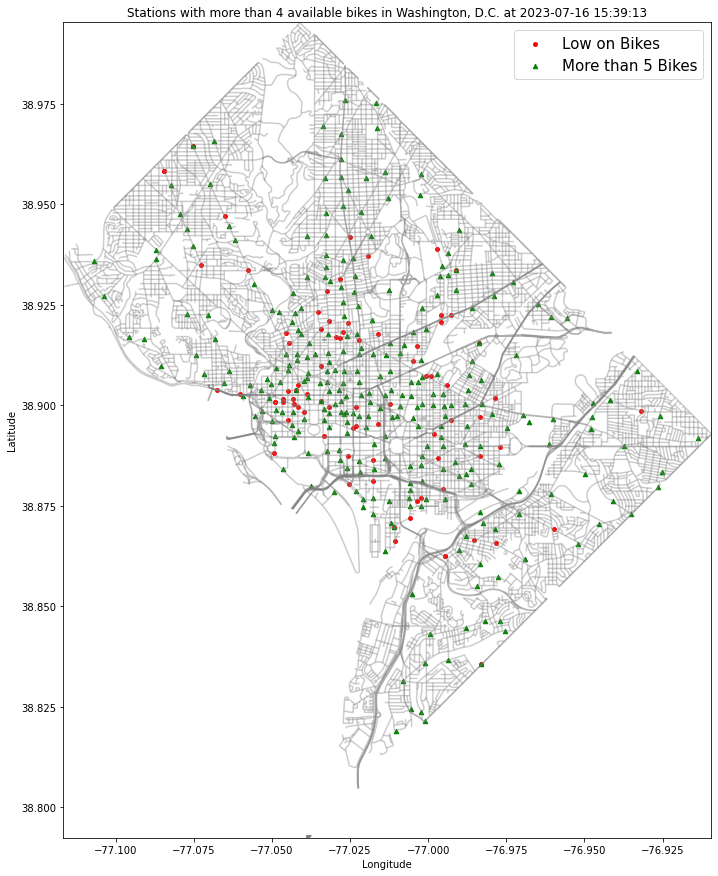

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
washington.plot(ax=ax, alpha=0.4, color='grey')
geo_df[geo_df['num_bikes_available'] <= 3].plot(ax=ax, 
                                       markersize=15, 
                                       color='red', 
                                       marker='o', 
                                       label='Low on Bikes')
geo_df[geo_df['num_bikes_available'] >= 4].plot(ax=ax, 
                                       markersize=20, 
                                       color='green', 
                                       marker='^', 
                                       label='More than 5 Bikes')
# Set the plot extent to Washington, D.C.
ax.set_xlim(washington.total_bounds[0], washington.total_bounds[2])
ax.set_ylim(washington.total_bounds[1], washington.total_bounds[3])

updated_time = df_stations_merged.iloc[1,10]

# Customize the map appearance (optional)
ax.set_title(f"Stations with more than 4 available bikes in Washington, D.C. at {updated_time}")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.legend(prop={'size':15})
# Display the map
plt.show()

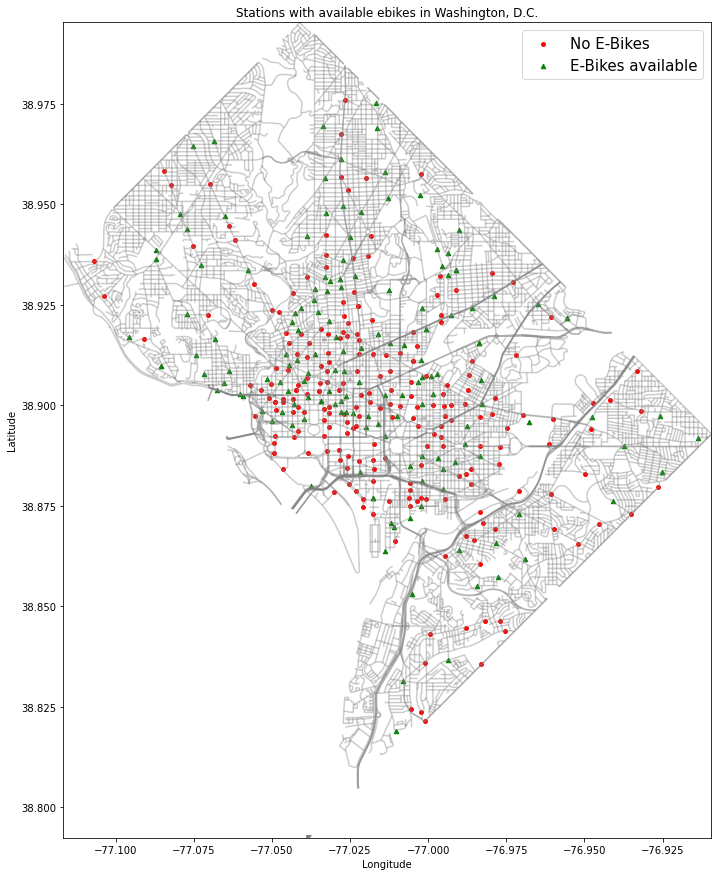

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
washington.plot(ax=ax, alpha=0.4, color='grey')
geo_df[geo_df['num_ebikes_available'] == 0].plot(ax=ax, 
                                       markersize=15, 
                                       color='red', 
                                       marker='o', 
                                       label='No E-Bikes')
geo_df[geo_df['num_ebikes_available'] > 0].plot(ax=ax, 
                                       markersize=20, 
                                       color='green', 
                                       marker='^', 
                                       label='E-Bikes available')
# Set the plot extent to Washington, D.C.
ax.set_xlim(washington.total_bounds[0], washington.total_bounds[2])
ax.set_ylim(washington.total_bounds[1], washington.total_bounds[3])

updated_time = df_stations_merged.iloc[1,10]

# Customize the map appearance (optional)
ax.set_title(f"Stations with available ebikes in Washington, D.C. at {updated_time}")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.legend(prop={'size':15})
# Display the map
plt.show()